In [101]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn import set_config; set_config(display='diagram')
from sklearn.preprocessing import OneHotEncoder
# Algorithms
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Data

In [102]:
data=pd.read_csv(r"C:\Users\Amani\Desktop\emission_co2\greenwashing\Data\2016_Building_Energy_Benchmarking.csv")

In [103]:
#supression des lignes qui ne renseigne pas sur LargestPropertyUseTypeGFA
data = data.dropna(subset=["LargestPropertyUseTypeGFA"])

In [104]:
#drop toutes les données de relève
data = data.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)'], axis=1)

In [105]:
#CHANGER le type de données en objet
data['CouncilDistrictCode']=data['CouncilDistrictCode'].astype('object')
data['ComplianceStatus']=data['ComplianceStatus'].astype('object')
data['DefaultData']=data['DefaultData'].astype('bool')
data['ComplianceStatus']=data['ComplianceStatus'].astype('object')
data= data.replace([-np.inf,np.inf], np.nan)


#### Nan

In [62]:
df_nan = pd.DataFrame({'Nan':data.isna().sum()})
df_nan['%nan'] = df_nan['Nan']/data.shape[0]*100
round(df_nan,2).sort_values(by='%nan' , ascending=False)

,Nan,%nan
Comments,3356,100.00
Outlier,3324,99.05
YearsENERGYSTARCertified,3237,96.45
ThirdLargestPropertyUseType,2760,82.24
ThirdLargestPropertyUseTypeGFA,2760,82.24
SecondLargestPropertyUseType,1677,49.97
SecondLargestPropertyUseTypeGFA,1677,49.97
ENERGYSTARScore,830,24.73
ZipCode,16,0.48
SiteEUI(kBtu/sf),2,0.06


In [63]:
for key in list(data.keys()):
    if data[key].nunique()<20:
        print(key,'------->', data[key].unique())
    else:
        print(key, '------->',data[key].nunique())

OSEBuildingID -------> 3356
DataYear -------> [2016]
BuildingType -------> ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']
PrimaryPropertyType -------> 24
PropertyName -------> 3342
Address -------> 3334
City -------> ['Seattle']
State -------> ['WA']
ZipCode -------> 55
TaxParcelIdentificationNumber -------> 3248
CouncilDistrictCode -------> [7 3 2 4 5 6 1]
Neighborhood -------> ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']
Latitude -------> 2864
Longitude -------> 2642
YearBuilt -------> 113
NumberofBuildings -------> [  1.   3.   0.   2.   4.  27.   6.  11.  14.   9.   5.   7.   8.  16.
  23.  10. 111.]
NumberofFloors -------> 50
PropertyGFATotal -------> 3176
PropertyGFAParking -

In [106]:
#La TaxParceliIntificationNumber est de type object alors qu'elle doit etre numerique.
# eliminons les lignes non numeriques de cette variable
data = data[data.TaxParcelIdentificationNumber.str.isnumeric()]
print(data.shape)


(3353, 43)


In [107]:
data["TaxParcelIdentificationNumber"] = pd.to_numeric(data["TaxParcelIdentificationNumber"])

In [108]:
#au lieu d'etudier l'année de construction de batiment , on va ajouter l'age de batiment
#apres on drop YearBuilt et DataYear 
data['BuildingAge'] = data['DataYear'] - data['YearBuilt']

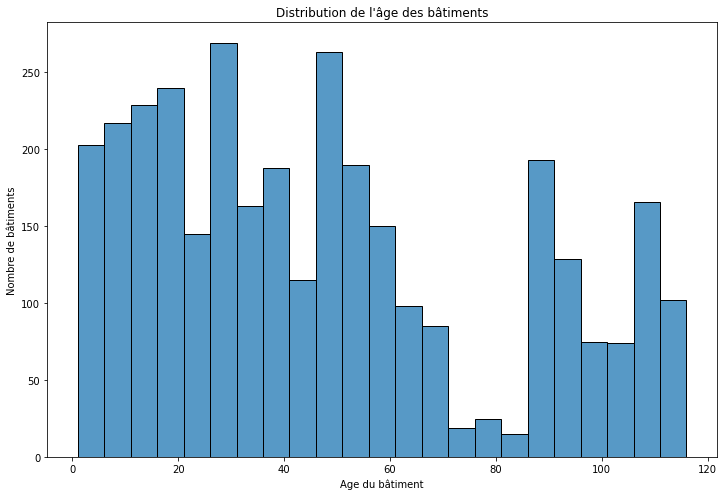

In [67]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=data, x='BuildingAge', bins=int((data.BuildingAge.max() - data.BuildingAge.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title("Distribution de l'âge des bâtiments")
plt.show()

In [68]:
#supprimer les colonnes inutiles:EBuildingID
#supprimer les colonnes qui ont  plus  90% de nan:YearsENERGYSTARCertified,comments
#supprimerles colonnes YearBuilt et DataYear apres l'ajout la    colonne BuildingAge
#supprimer la colonne en kWh qui est redondante et ainsi rester celui en kBtu, uniformément avec le reste des colonnes
# garder aussi cette unité pour le gaz.(drop 'Electricity(kWh)', 'NaturalGas(therms))
#L'émission de gaz à effet de serre est liée de façon directe à la consommation d'énergie, 
#  donc les données normalisée en fonction des conditions climatiques ne sont pas inetresses
# (drop 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)')
#on garde que lon et lat et supprimer les colonne :'PropertyName', 'Address', 'City', 'State', 'ZipCode'

In [109]:
#supprimer les lignes répertoriées comme des outliers avant de supprimer la colonne(Outlier)
data = data[data['Outlier'].isnull()] 


In [110]:
drop_cloumns = ['Outlier', 'OSEBuildingID', 'YearsENERGYSTARCertified', 'Comments', 'YearBuilt', 'DataYear', 'Electricity(kWh)', 'NaturalGas(therms)',
                'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'PropertyName', 'Address', 'City', 'State', 'ZipCode']
for column in drop_cloumns:
    try:
        data.drop(column, axis='columns', inplace=True)
    except:
        print(f'column {column} not present')


In [111]:
#remplacer le nan 
# Using MODE for categorical columns
#Using median for numeric  columns

for index, value in data.dtypes.items(): 
    if value == 'object':
        data[index].fillna(data[index].mode()[0], inplace=True)
    else:
        data[index].replace(to_replace = np.nan, value = data[index].median(), inplace= True)

In [112]:
##### modifier le contenu de la colonne Neighborhood 
data['Neighborhood'].replace('Delridge', 'DELRIDGE', inplace=True)
data['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
data['Neighborhood'].replace('North', 'NORTH', inplace=True)
data['Neighborhood'].replace('Northwest', 'NORTHWEST', inplace=True)
data['Neighborhood'].replace('Central', 'CENTRAL', inplace=True)
data['Neighborhood'].replace('Ballard', 'BALLARD', inplace=True)

In [73]:
def split_words(df, column = None):
  list_words = set()
  for word in df[column].str.split(','):
    if isinstance(word, float):
      continue
    list_words = set().union(word, list_words)
  return list(list_words)

list_use_type = split_words(data, 'ListOfAllPropertyUseTypes')
print("Nombre de type d'usages dans la base : {}".format(len(list_use_type)))

Nombre de type d'usages dans la base : 115


In [113]:
#il y a 115  type d'usages ,c'est difficile de l'encoder apres 
# Nous allons donc créer une variable nous donnant le nombre total d'usage du bâtiment,
#  puis supprimer la liste complète des usages
data['TotalUseTypeNumber'] = [str(word).count(",") + 1 for word in data['ListOfAllPropertyUseTypes'].str.split(',')]
data.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)

### Analyse exploratoire

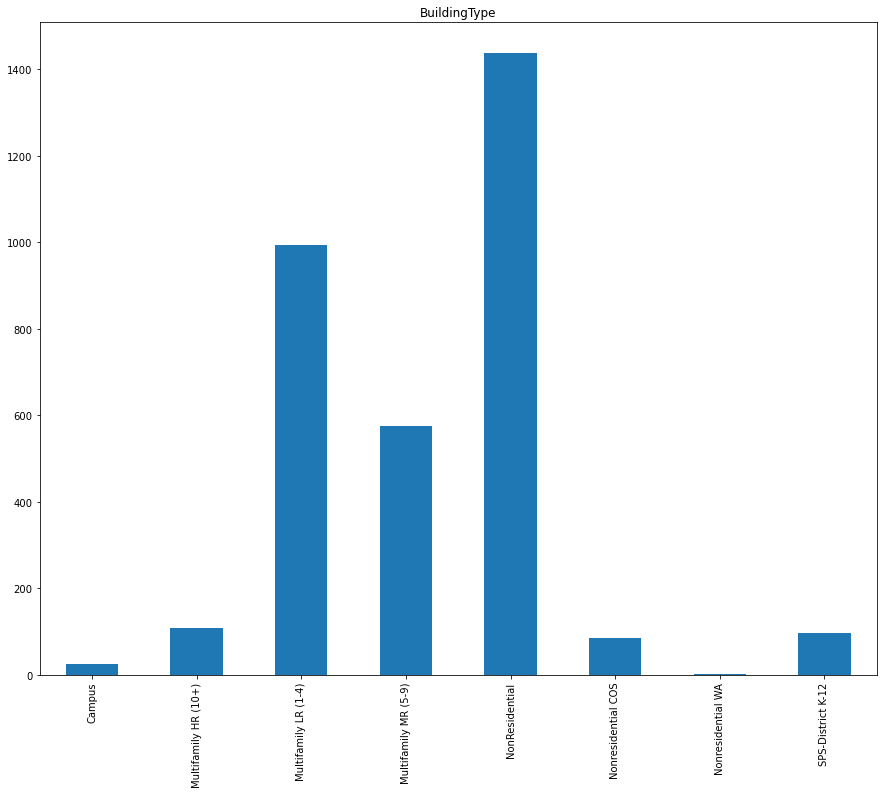

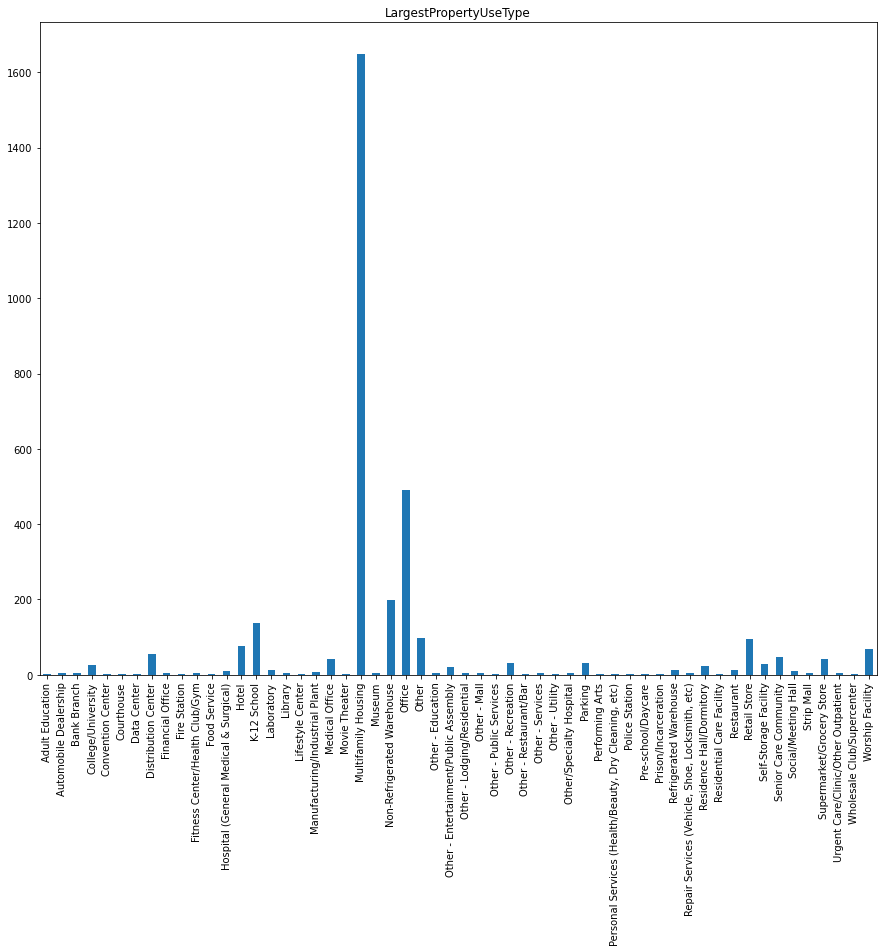

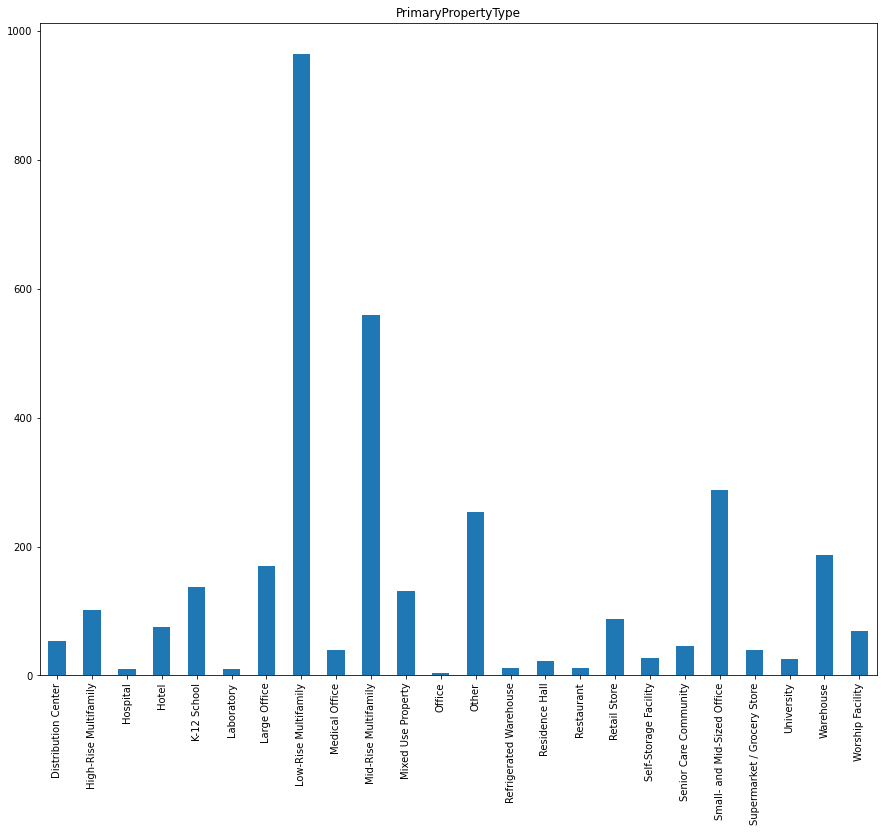

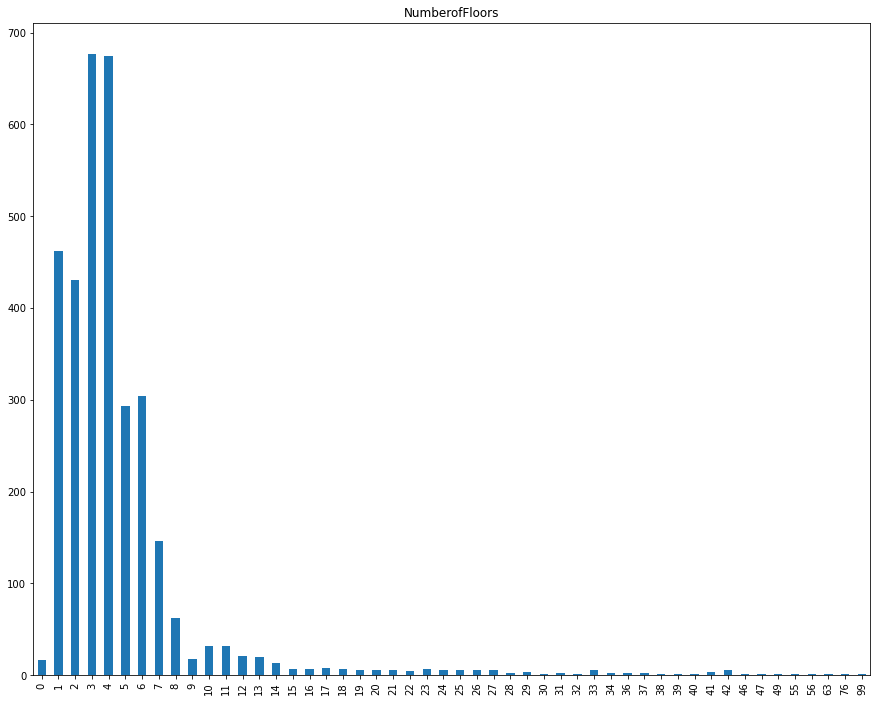

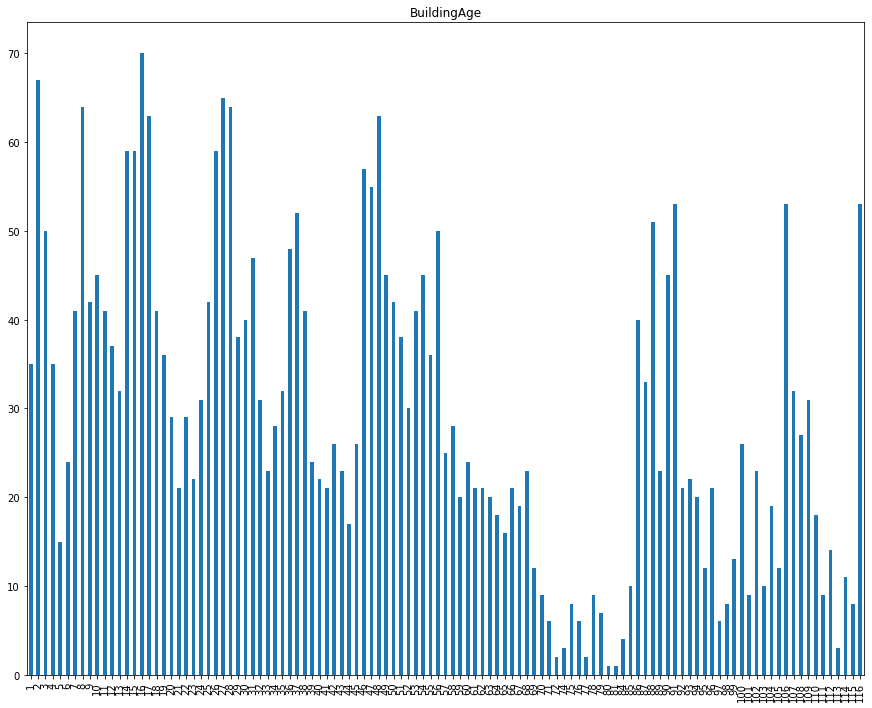

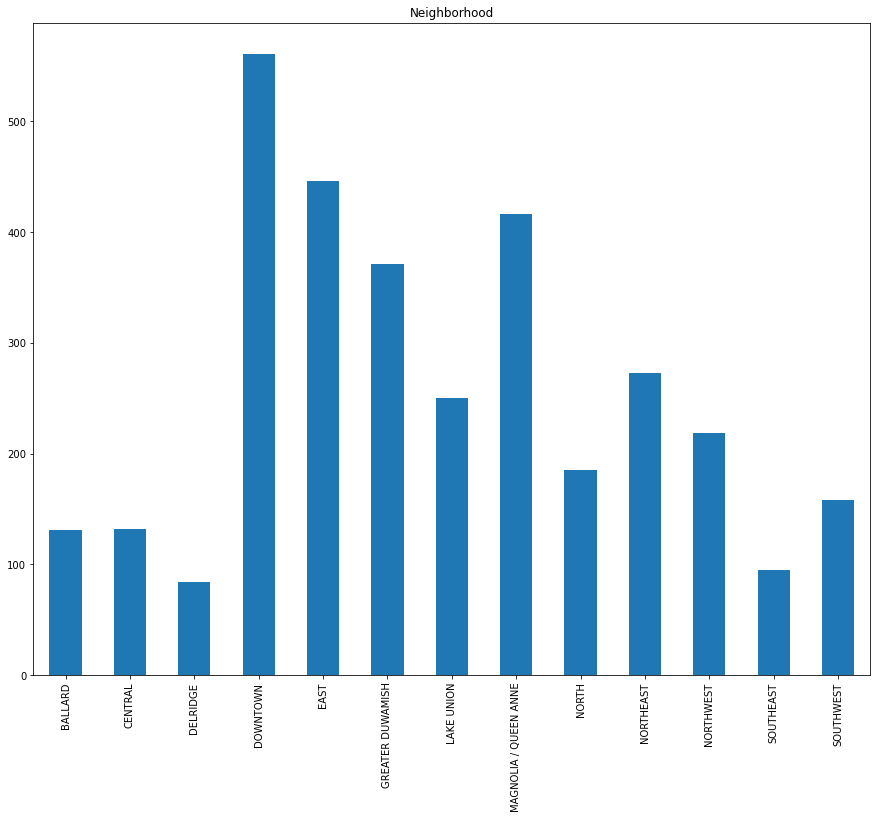

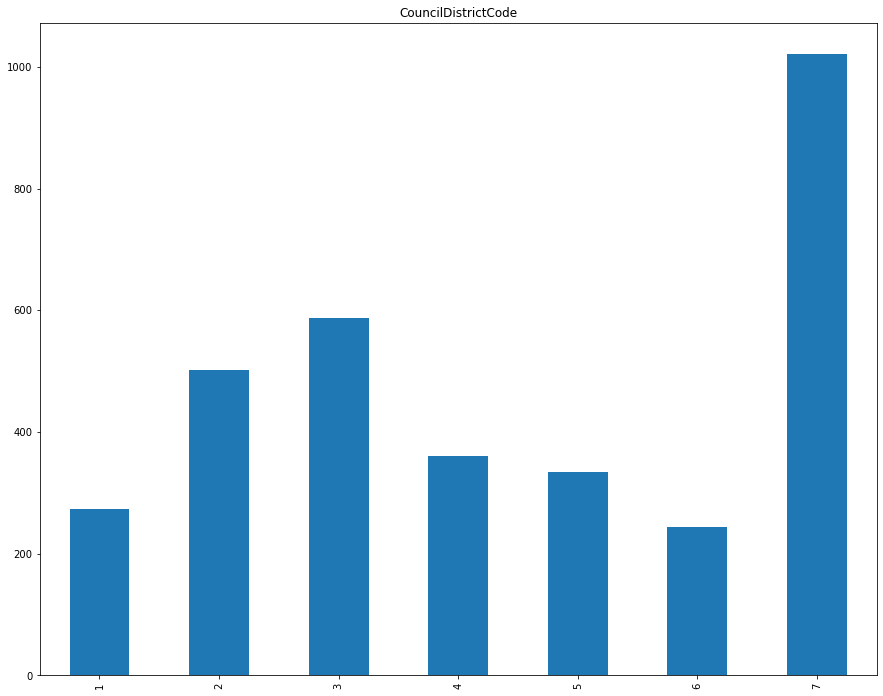

In [75]:
qualitative_columns = ['BuildingType', 'LargestPropertyUseType', 'PrimaryPropertyType', 'NumberofFloors','BuildingAge', 
                       'Neighborhood', 'CouncilDistrictCode']

for column in qualitative_columns:
    fig = plt.figure(figsize=(15,12))
    data[column].value_counts().sort_index(axis=0).plot(kind='bar')
    plt.title(column)
    plt.show()

In [76]:

#les types de batiments sont inégalement représentés, on a surtout des batiments de types NonResidential 
# qui sont essentiellement des Multifamily Housing 



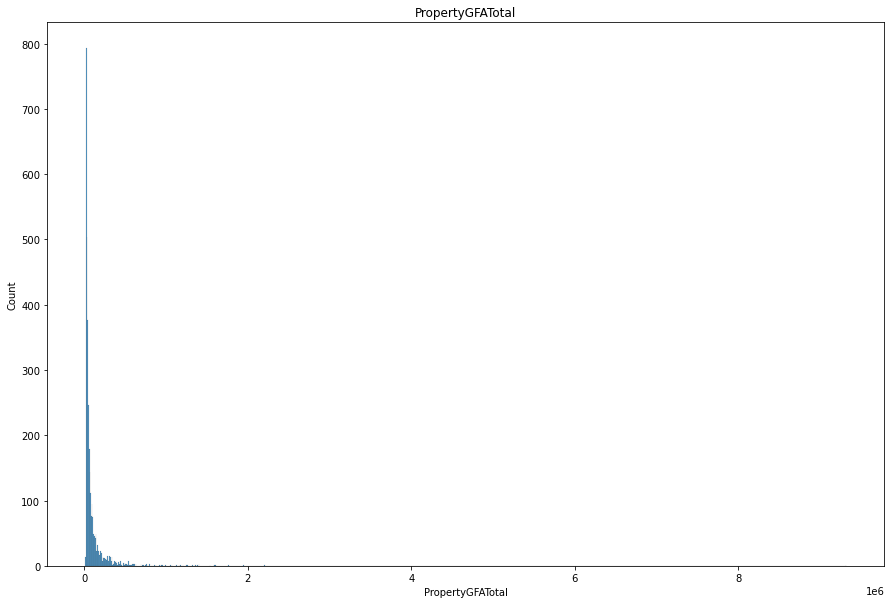

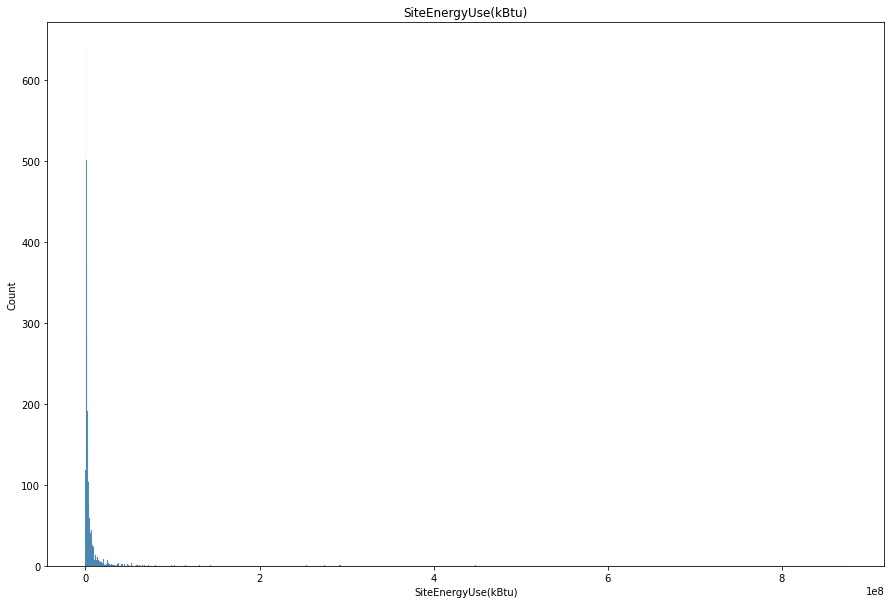

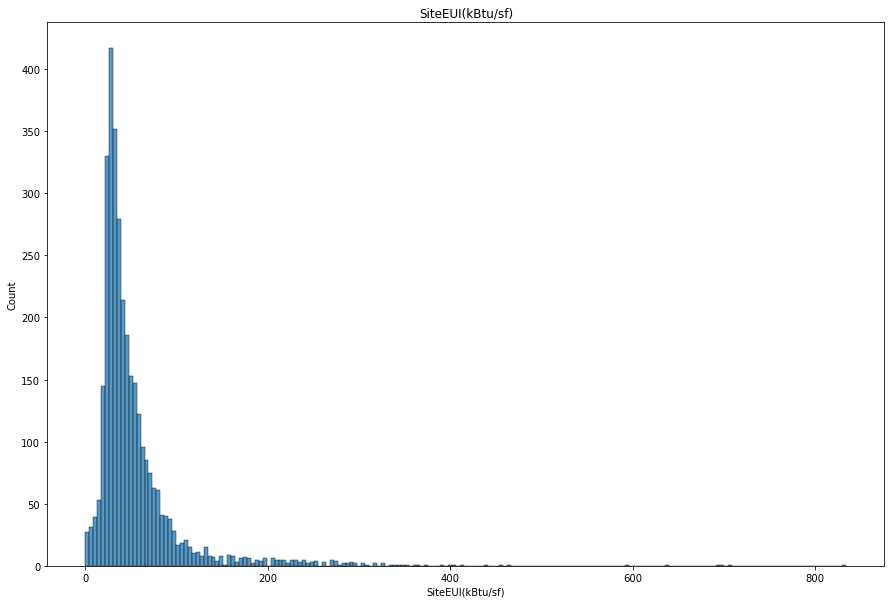

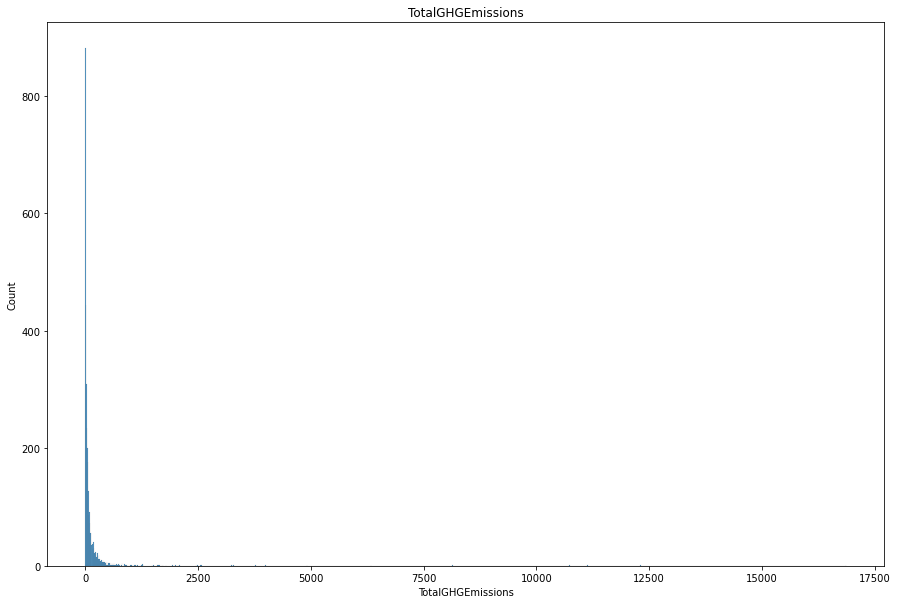

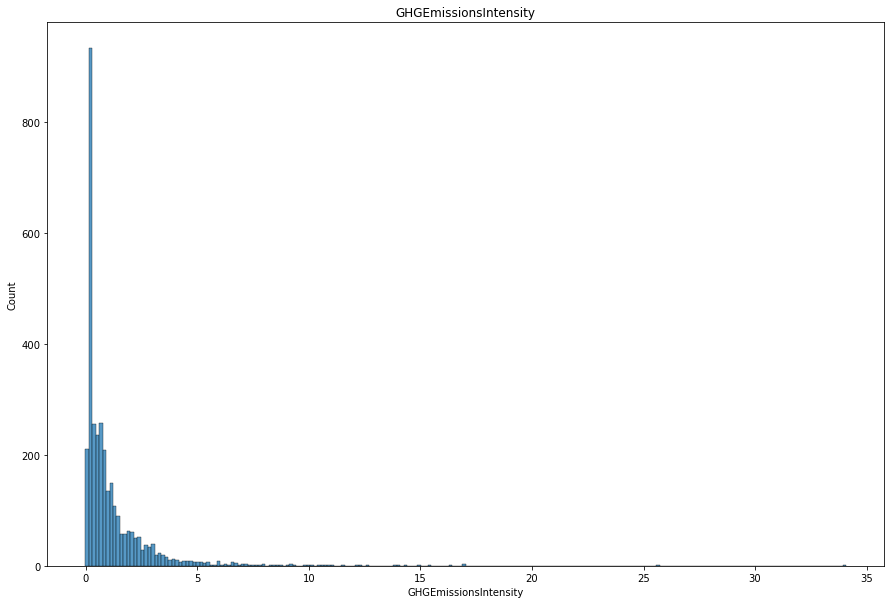

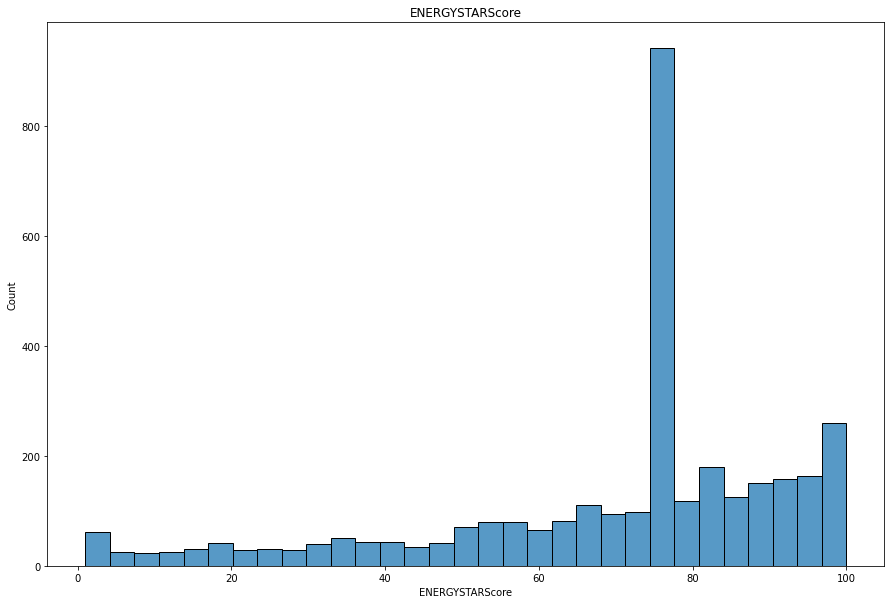

In [77]:
quantitative_columns = ['PropertyGFATotal', 'SiteEnergyUse(kBtu)', 
                        'SiteEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ENERGYSTARScore']
for column in quantitative_columns:
    fig = plt.figure(figsize=(15,10))
    sns.histplot(data[column])
    plt.title(column)
    plt.show()

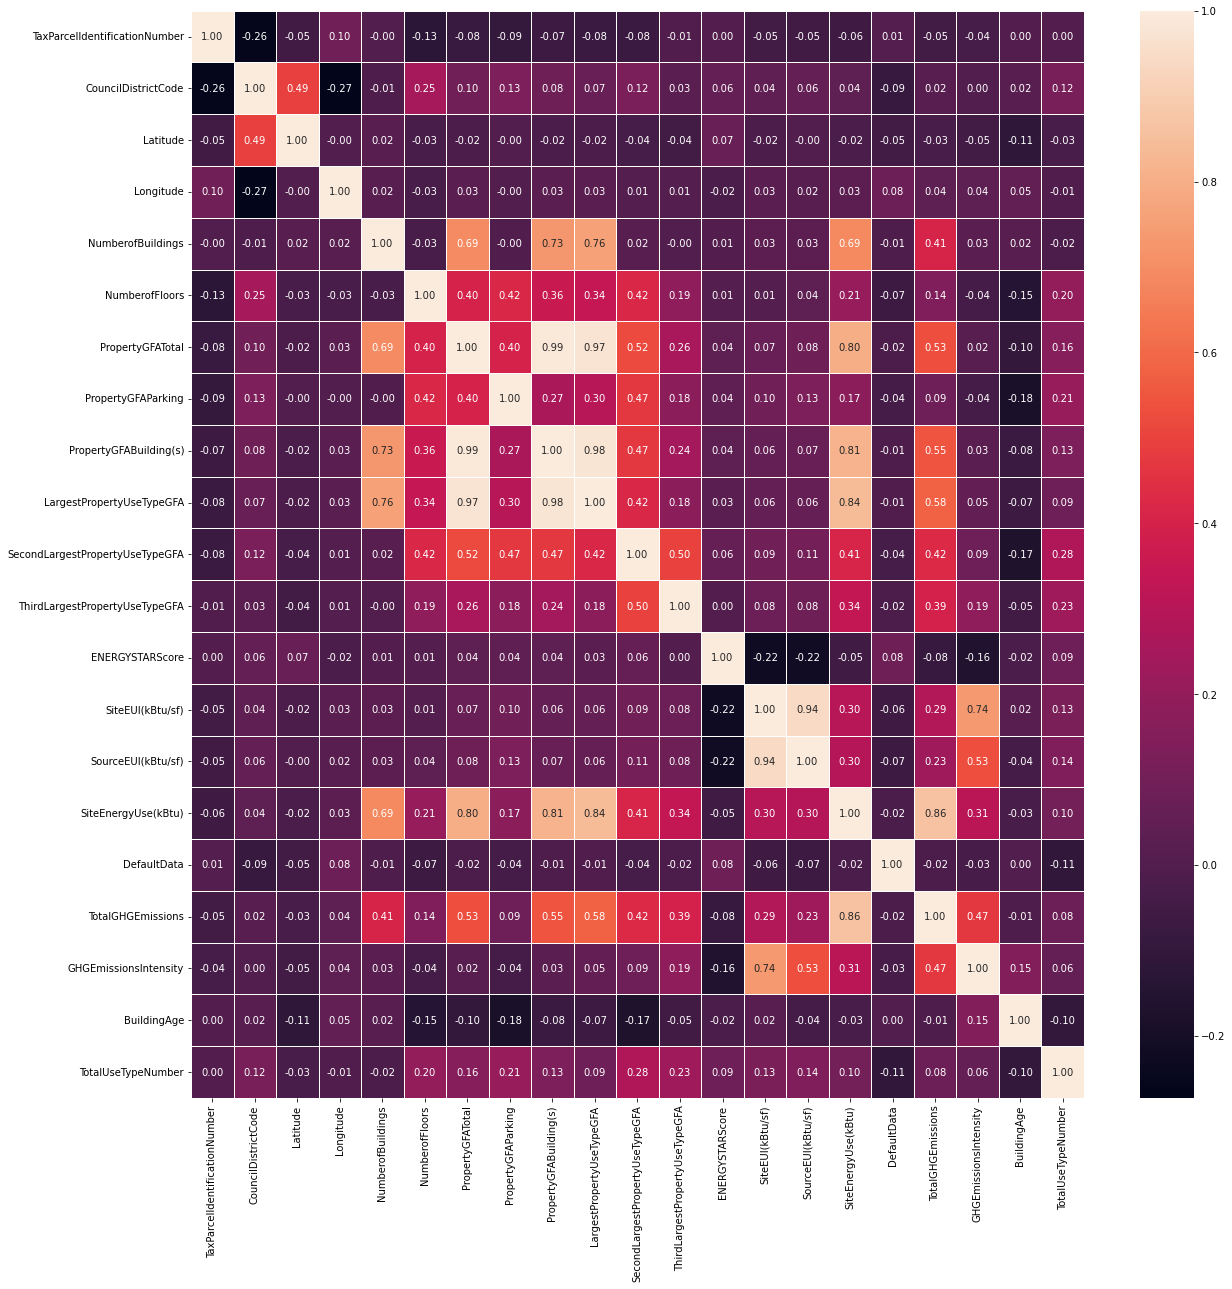

In [78]:

# Heatmap

fig, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(data.corr(), annot = True, fmt = '1.2f', annot_kws = {'size' : 10}, linewidth = 1)
plt.show()

In [79]:
threshold = 0.7
corr=data.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False) 

,level_0,level_1,corr_coeff
20,PropertyGFATotal,PropertyGFABuilding(s),0.989828
18,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.978464
16,PropertyGFATotal,LargestPropertyUseTypeGFA,0.974159
14,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),0.943820
12,TotalGHGEmissions,SiteEnergyUse(kBtu),0.862987
10,SiteEnergyUse(kBtu),LargestPropertyUseTypeGFA,0.836692
8,SiteEnergyUse(kBtu),PropertyGFABuilding(s),0.812340
6,SiteEnergyUse(kBtu),PropertyGFATotal,0.797151
4,LargestPropertyUseTypeGFA,NumberofBuildings,0.759101
2,SiteEUI(kBtu/sf),GHGEmissionsIntensity,0.735390


In [80]:
#il ya une multi colineartiées fortes  entre plusieurs variables

In [114]:
#convertir les différentes surfaces (Buildings et Parking) en pourcentage de
# la surface totale et nous conserverons uniquement ces 2 variables en supprimant 
# les variables LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA :
#parce qu'elles sont en fortes correlations
#On calcule les ratios
data['GFABuildingRate'] = (round((data['PropertyGFABuilding(s)'].fillna(0)
                                  /data['PropertyGFATotal'].fillna(0)),5))
data['GFAParkingRate'] = (round((data['PropertyGFAParking'].fillna(0)
                                 /data['PropertyGFATotal'].fillna(0)),5))
#On supprime les variables inutiles
data=data.drop(['LargestPropertyUseTypeGFA', 
           'SecondLargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType',
           'PropertyGFAParking',
           'PropertyGFABuilding(s)'],
         axis=1)

In [115]:
#####Nous pouvons également calculer la surface moyenne par bâtiment et par étage
data['GFAPerBuilding'] = round((data['PropertyGFATotal'] / data['NumberofBuildings']),3)
data['GFAPerFloor'] = round((data['PropertyGFATotal'] / data['NumberofFloors']),3)

<Figure size 360x360 with 0 Axes>

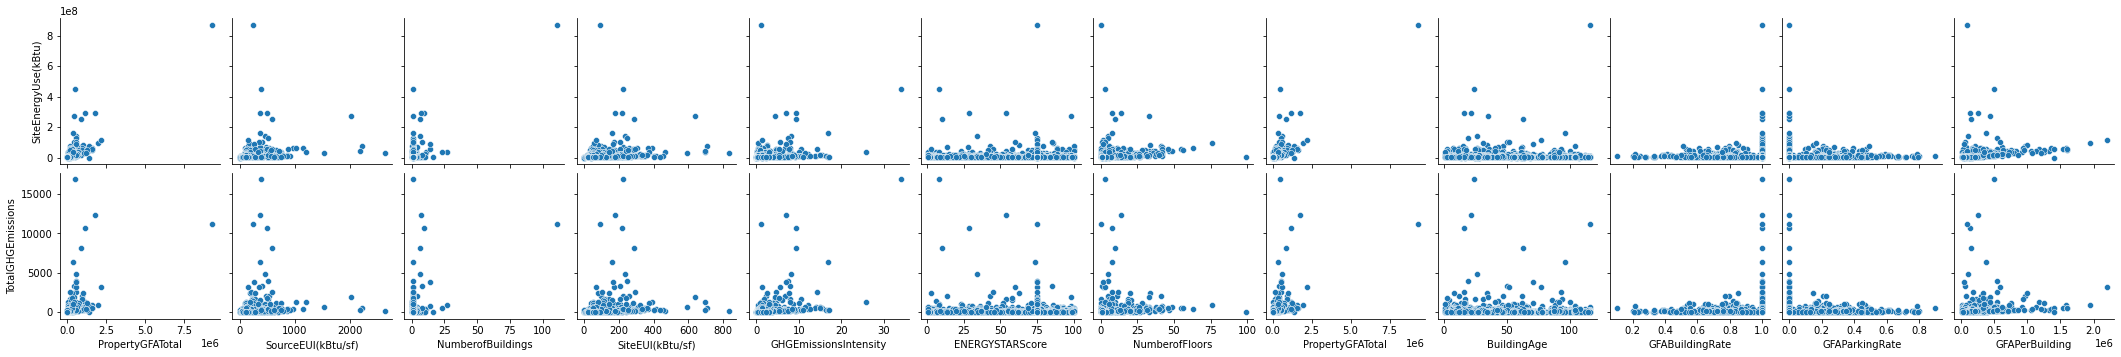

In [83]:
# Correlation entre entrées et sorties
plt.figure(figsize=(5,5))
sns.pairplot(data=data, y_vars=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'],
             x_vars=['PropertyGFATotal', 'SourceEUI(kBtu/sf)','NumberofBuildings',
                        'SiteEUI(kBtu/sf)', 'GHGEmissionsIntensity',  'ENERGYSTARScore','NumberofFloors',
                        'PropertyGFATotal','BuildingAge','GFABuildingRate','GFAParkingRate','GFAPerBuilding'])
plt.show()

In [116]:
#changer le type de lon et lat pour n'est pas supprimer les valuers négative
data[["Longitude","Latitude"]]=data[["Longitude","Latitude"]].astype('O')

In [118]:
#Coordonnées du centre de Seattle
#calcule la distance 
from math import radians, cos, sin, asin, sqrt
seattle_lat = 47.6062
seattle_lon = -122.3321

def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [119]:
#Calcul des distance au centre de Seattle pour chaque point
data['harvesine_distance'] = [haversine_distance(seattle_lat, seattle_lon, x, y) 
                              for x, y in zip(data.Latitude.astype(float), data.Longitude.astype(float))]

In [120]:
data=data.drop(["Longitude","Latitude"],axis=1)

In [121]:
data.describe()

,TaxParcelIdentificationNumber,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
count,3.321000e+03,3321.000000,3321.000000,3321.000000,3.321000e+03,3321.000000,3321.000000,3321.000000,3.321000e+03,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000,3321.0,3321.000,3321.000000
mean,4.291124e+09,4.444143,1.106594,4.715146,9.543086e+04,69.630232,54.790304,134.287775,5.429104e+06,120.294490,1.176558,47.246612,1.794339,0.958321,0.041679,inf,inf,2.967650
std,2.962078e+09,2.118186,2.122049,5.518166,2.204745e+05,23.365353,56.018179,138.035399,2.175351e+07,542.250309,1.816213,33.000361,1.081962,0.115143,0.115143,NaN,NaN,2.287981
min,1.800021e+06,1.000000,0.000000,0.000000,1.128500e+04,1.000000,0.000000,0.000000,0.000000e+00,-0.800000,-0.020000,1.000000,1.000000,0.104980,0.000000,4300.0,221.697,0.015490
25%,1.975701e+09,3.000000,1.000000,2.000000,2.850000e+04,61.000000,28.100000,75.000000,9.355803e+05,9.660000,0.210000,19.000000,1.000000,1.000000,0.000000,28176.0,8666.667,1.011859
50%,3.448002e+09,4.000000,1.000000,4.000000,4.443200e+04,75.000000,38.799999,96.400002,1.809587e+06,34.140000,0.620000,41.000000,1.000000,1.000000,0.000000,44352.0,14056.333,2.304614
75%,7.117500e+09,7.000000,1.000000,5.000000,9.152000e+04,85.000000,60.400002,143.899994,4.224872e+06,94.010000,1.370000,67.000000,2.000000,1.000000,0.000000,94470.0,26450.500,4.420259
max,5.569640e+10,7.000000,111.000000,99.000000,9.320156e+06,100.000000,834.400024,2620.000000,8.739237e+08,16870.980000,34.090000,116.000000,11.000000,1.000000,0.895020,inf,inf,8.969855


In [130]:
data= data.replace([-np.inf,np.inf], np.nan)
data = data.dropna(subset=["GFAPerBuilding","GFAPerFloor"])

In [131]:
data.describe()

,TaxParcelIdentificationNumber,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
count,3.213000e+03,3213.000000,3213.000000,3213.000000,3.213000e+03,3213.000000,3213.000000,3213.000000,3.213000e+03,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3.213000e+03,3.213000e+03,3213.000000
mean,4.299121e+09,4.450358,1.099595,4.749455,9.174941e+04,69.733582,54.226268,133.138189,5.085787e+06,115.033252,1.159150,47.229069,1.789605,0.957818,0.042182,8.777575e+04,2.374812e+04,2.985217
std,2.966418e+09,2.118628,0.905588,5.567689,1.498362e+05,23.359886,54.928599,137.466065,1.576040e+07,512.509426,1.759175,32.982586,1.075565,0.115748,0.115748,1.428217e+05,3.653814e+04,2.290920
min,1.800021e+06,1.000000,1.000000,1.000000,1.128500e+04,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.104980,0.000000,4.300000e+03,2.216970e+02,0.015490
25%,1.976200e+09,3.000000,1.000000,2.000000,2.845300e+04,61.000000,28.000000,74.900002,9.303685e+05,9.570000,0.210000,19.000000,1.000000,1.000000,0.000000,2.785200e+04,8.647667e+03,1.024500
50%,3.467800e+09,4.000000,1.000000,4.000000,4.401600e+04,75.000000,38.700001,96.000000,1.788148e+06,33.850000,0.610000,41.000000,1.000000,1.000000,0.000000,4.318300e+04,1.401850e+04,2.344357
75%,7.129305e+09,7.000000,1.000000,5.000000,9.000000e+04,85.000000,59.700001,142.399994,4.169432e+06,92.520000,1.370000,67.000000,2.000000,1.000000,0.000000,8.726200e+04,2.630450e+04,4.453102
max,5.569640e+10,7.000000,27.000000,99.000000,2.200000e+06,100.000000,834.400024,2620.000000,4.483853e+08,16870.980000,34.090000,116.000000,11.000000,1.000000,0.895020,2.200000e+06,1.100000e+06,8.969855


In [132]:
#supprimer les valeurs négatives pour les colonnes nemeriques
data=data[data.select_dtypes(include=[np.number]).ge(0).all(1)]

In [137]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
data_vif=data.select_dtypes(exclude=['object'])

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)
data_vif=data.select_dtypes(exclude=['object']).drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'],axis=1)
calc_vif( data_vif)

,variables,VIF
0,NumberofBuildings,1.608180
1,NumberofFloors,2.689819
2,PropertyGFATotal,18.598059
3,SiteEUI(kBtu/sf),2.249508
4,GHGEmissionsIntensity,2.243286
5,BuildingAge,1.248078
6,TotalUseTypeNumber,1.115874
7,GFABuildingRate,15.033570
8,GFAParkingRate,1.477617
9,GFAPerBuilding,18.692517


TaxParcelIdentificationNumber       AxesSubplot(0.125,0.772143;0.133621x0.107857)
CouncilDistrictCode              AxesSubplot(0.285345,0.772143;0.133621x0.107857)
NumberofBuildings                 AxesSubplot(0.44569,0.772143;0.133621x0.107857)
NumberofFloors                   AxesSubplot(0.606034,0.772143;0.133621x0.107857)
PropertyGFATotal                 AxesSubplot(0.766379,0.772143;0.133621x0.107857)
ENERGYSTARScore                     AxesSubplot(0.125,0.642714;0.133621x0.107857)
SiteEUI(kBtu/sf)                 AxesSubplot(0.285345,0.642714;0.133621x0.107857)
SourceEUI(kBtu/sf)                AxesSubplot(0.44569,0.642714;0.133621x0.107857)
SiteEnergyUse(kBtu)              AxesSubplot(0.606034,0.642714;0.133621x0.107857)
TotalGHGEmissions                AxesSubplot(0.766379,0.642714;0.133621x0.107857)
GHGEmissionsIntensity               AxesSubplot(0.125,0.513286;0.133621x0.107857)
BuildingAge                      AxesSubplot(0.285345,0.513286;0.133621x0.107857)
TotalUseTypeNumb

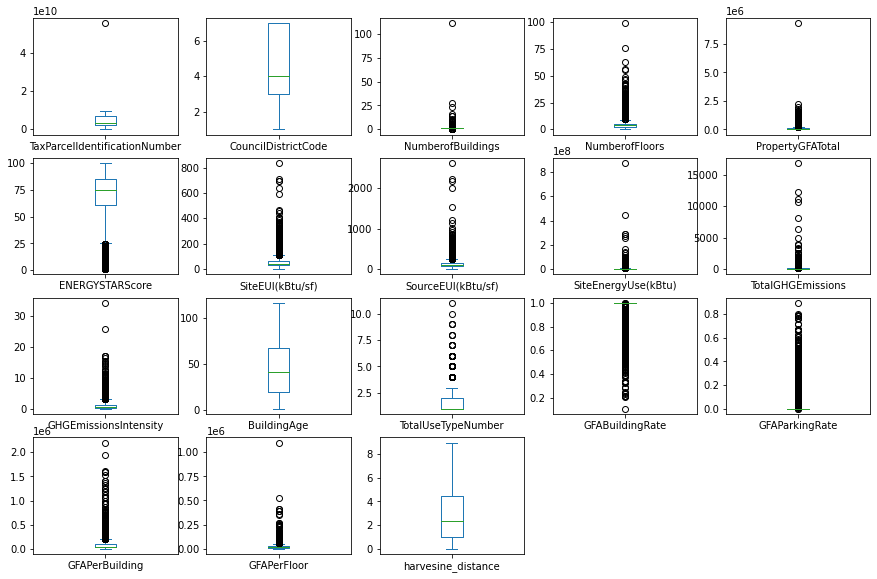

In [123]:
data.plot(kind='box', subplots=True, layout=(6, 5), figsize = (15, 15))

In [88]:
#il y a queleque outliers  on va utilser un Robustscaler pour les données de type nemerique et onehotencoder pour les 
# de type objet pour le model

### La distribution de TARGET

In [89]:
#pour les 0 dans les deux targets : il manque des données , pour regler ce probleme on peut faire la pediction pour
 # les colonnes qui ont tres important pour  notre model , il existe plusieurs technique pour ce probleme
 #   suivant la linearité(scatter plot ) des données on peut faire un choix entre : prediction lineaire ou polynomiale 
 # pour le moment on va appliquer log + 1  pour resoudre ce probleme ou on peut supprimer ces données (seulement 18 lignes)
 # peut etre traiter plus tard               

In [90]:
data[data['TotalGHGEmissions']==0]

,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
28,SPS-District K-12,K-12 School,688000090,3,CENTRAL,47.62266,-122.30547,1.0,1,126351,...,False,Missing Data,0.0,0.0,61,1,1.00000,0.00000,126351.0,126351.000
152,SPS-District K-12,K-12 School,5100404840,5,NORTH,47.69823,-122.32126,1.0,2,52792,...,False,Missing Data,0.0,0.0,27,1,1.00000,0.00000,52792.0,26396.000
304,NonResidential,Other,1978200105,7,DOWNTOWN,47.61195,-122.33167,1.0,6,1400000,...,False,Non-Compliant,0.0,0.0,26,2,1.00000,0.00000,1400000.0,233333.333
513,NonResidential,Supermarket / Grocery Store,7666201460,7,MAGNOLIA / QUEEN ANNE,47.63718,-122.37734,1.0,1,57176,...,False,Compliant,0.0,0.0,8,5,1.00000,0.00000,57176.0,57176.000
746,NonResidential,Other,164000020,5,NORTHWEST,47.72777,-122.34503,1.0,1,29924,...,False,Missing Data,0.0,0.0,14,1,1.00000,0.00000,29924.0,29924.000
760,Multifamily LR (1-4),Other,246300000,7,DOWNTOWN,47.61294,-122.34638,1.0,3,30700,...,False,Missing Data,0.0,0.0,107,2,1.00000,0.00000,30700.0,10233.333
1323,Multifamily LR (1-4),Low-Rise Multifamily,2025049091,4,LAKE UNION,47.64272,-122.32866,1.0,4,37361,...,False,Compliant,0.0,0.0,42,1,0.87326,0.12674,37361.0,9340.250
1361,SPS-District K-12,K-12 School,2126049041,5,NORTH,47.72369,-122.30676,1.0,1,42292,...,True,Error - Correct Default Data,0.0,0.0,62,1,1.00000,0.00000,42292.0,42292.000
1549,Multifamily LR (1-4),Low-Rise Multifamily,2607980000,5,NORTH,47.71965,-122.31877,1.0,4,47647,...,False,Non-Compliant,0.0,0.0,28,1,1.00000,0.00000,47647.0,11911.750


In [91]:
data[data['SiteEnergyUse(kBtu)']==0]

,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
28,SPS-District K-12,K-12 School,688000090,3,CENTRAL,47.62266,-122.30547,1.0,1,126351,...,False,Missing Data,0.00,0.00,61,1,1.0,0.0,126351.0,126351.000
31,SPS-District K-12,K-12 School,809000005,7,MAGNOLIA / QUEEN ANNE,47.6329,-122.35172,1.0,2,51582,...,False,Missing Data,10.43,0.20,27,1,1.0,0.0,51582.0,25791.000
62,SPS-District K-12,K-12 School,2518400005,1,SOUTHWEST,47.5097,-122.37759,1.0,2,53352,...,False,Missing Data,4.19,0.08,68,1,1.0,0.0,53352.0,26676.000
81,SPS-District K-12,K-12 School,1324039116,1,DELRIDGE,47.5636,-122.358,1.0,3,74468,...,False,Missing Data,11.84,0.16,17,1,1.0,0.0,74468.0,24822.667
85,SPS-District K-12,K-12 School,1524049002,2,SOUTHEAST,47.57324,-122.29058,1.0,2,58933,...,False,Missing Data,16.36,0.28,25,1,1.0,0.0,58933.0,29466.500
95,SPS-District K-12,K-12 School,1931301145,6,LAKE UNION,47.65464,-122.34912,1.0,3,66588,...,False,Missing Data,14.67,0.22,25,1,1.0,0.0,66588.0,22196.000
133,SPS-District K-12,K-12 School,3526039131,6,BALLARD,47.69675,-122.3776,1.0,1,160270,...,False,Missing Data,229.38,1.43,57,1,1.0,0.0,160270.0,160270.000
139,SPS-District K-12,K-12 School,3646100540,3,CENTRAL,47.59796,-122.30415,1.0,3,136188,...,False,Missing Data,170.90,1.25,53,1,1.0,0.0,136188.0,45396.000
152,SPS-District K-12,K-12 School,5100404840,5,NORTH,47.69823,-122.32126,1.0,2,52792,...,False,Missing Data,0.00,0.00,27,1,1.0,0.0,52792.0,26396.000
304,NonResidential,Other,1978200105,7,DOWNTOWN,47.61195,-122.33167,1.0,6,1400000,...,False,Non-Compliant,0.00,0.00,26,2,1.0,0.0,1400000.0,233333.333


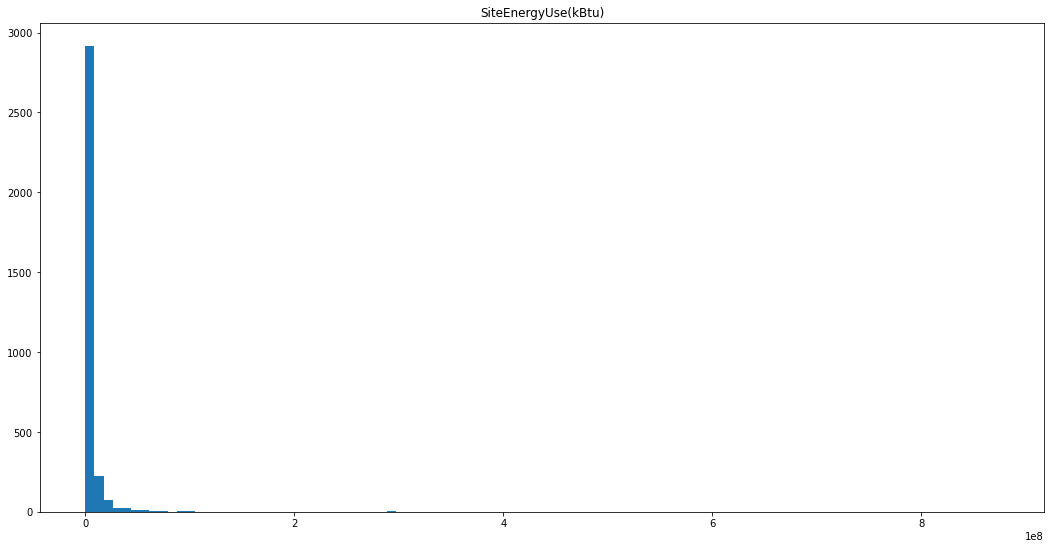

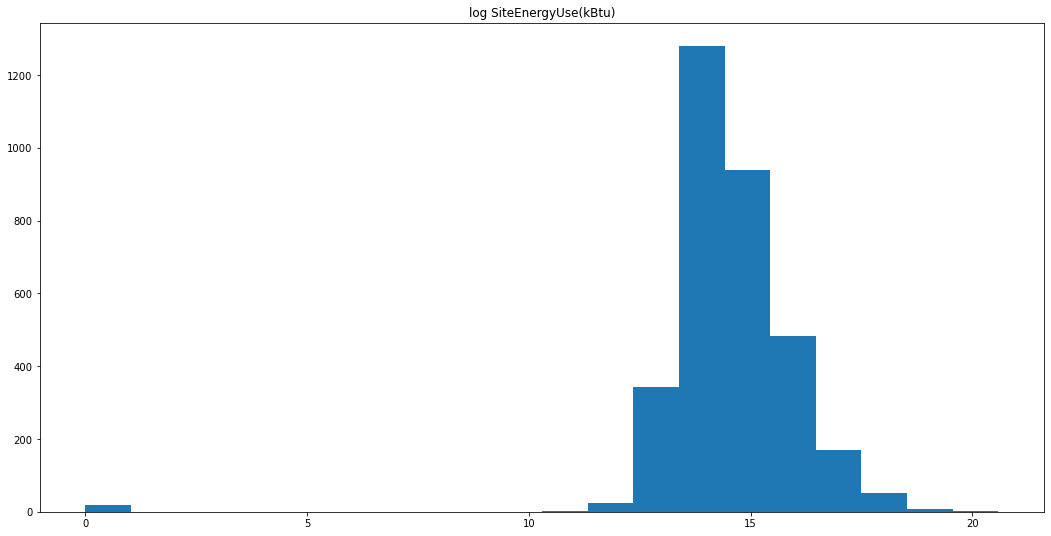

In [92]:
n_bins = 20
fig = plt.figure(figsize=(18,9))
plt.hist(data['SiteEnergyUse(kBtu)'],100)
plt.title('SiteEnergyUse(kBtu)')
plt.show()
fig = plt.figure(figsize=(18,9))
plt.hist(np.log(data['SiteEnergyUse(kBtu)']+1),n_bins)
plt.title('log SiteEnergyUse(kBtu)')
plt.show()

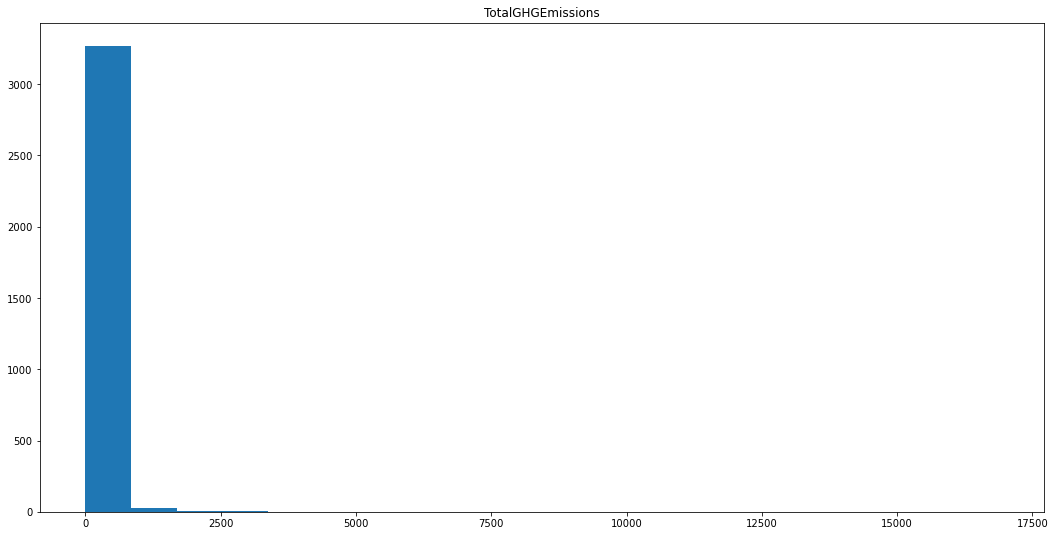

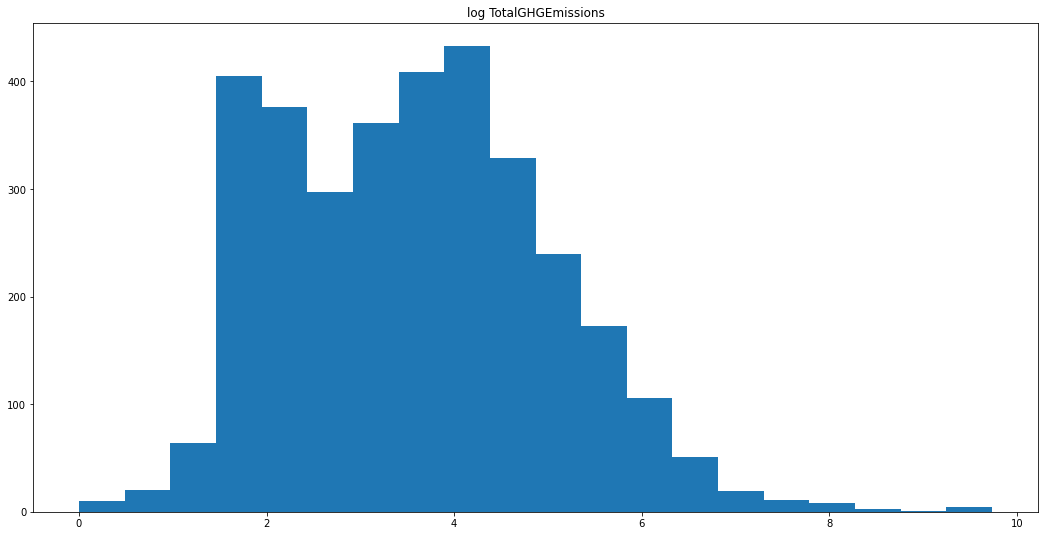

In [93]:
n_bins = 20
fig = plt.figure(figsize=(18,9))
plt.hist(data['TotalGHGEmissions'],n_bins)
plt.title('TotalGHGEmissions')
plt.show()
fig = plt.figure(figsize=(18,9))
plt.hist(np.log(data['TotalGHGEmissions']+1),n_bins)
plt.title('log TotalGHGEmissions')
plt.show()

In [94]:
#la distribution des données cibles pouvait devenir presque normale avec
#  une transformation logarithmique. Cela va réduire l'effet négatif des valeurs aberrantes dans l'ensemble d'apprentissage.

In [133]:
#drop colonnes qui ont pas d'importance pour le model 
data=data.drop(["TaxParcelIdentificationNumber","DefaultData",'CouncilDistrictCode','ENERGYSTARScore','SourceEUI(kBtu/sf)','ComplianceStatus'],axis=1)

In [136]:
data.to_csv("cleaning_data.csv")